In [1]:
from pickle import load
from math import ceil
from numpy.random import choice
from keras import Model, Sequential
from keras.applications import ResNet152V2
from keras.layers import Input, Dense, LSTM, Embedding, Add, Concatenate, Dropout
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from tensorflow import GradientTape, zeros, ones, concat, cast
from tensorflow.data import Dataset, AUTOTUNE

from tensorflow import data, zeros, int32, float32, tensor_scatter_nd_add, constant, convert_to_tensor

from functions.text_processing import create_vocab_mappings
from functions.training import data_generator
from functions.model_evaluation import evaluate_captions, generate_and_evaluate_caption

from keras.losses import binary_crossentropy, sparse_categorical_crossentropy 
import tensorflow
from tensorflow import reduce_mean
from tensorflow import data, zeros, int64, float32, tensor_scatter_nd_add, constant, convert_to_tensor
from tensorflow.math import argmax

from numpy import expand_dims, mean
from keras.utils import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

from functions.model_evaluation import decode_caption




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SEQ_LENGTH = 15
EMB_DIM = 300 # can only be values 100, 200, 300
HIDDEN_DIM = 512
EPOCHS = 100
DROPOUT = 0.4
BATCH_SIZE = 512
EVAL_BATCH_SIZE = 1024
DIR = 'preprocessed_data/coco/'

In [3]:
with open(DIR + 'train_caption_map.pkl', 'rb') as file:
    train_caption_map = load(file)
    
with open(DIR + 'train_feature_map.pkl', 'rb') as file:
    train_feature_map = load(file)

with open(DIR + 'val_caption_map.pkl', 'rb') as file:
    val_caption_map = load(file)
    
with open(DIR + 'val_feature_map.pkl', 'rb') as file:
    val_feature_map = load(file)

with open(DIR + 'embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
with open(DIR + 'vocab.pkl', 'rb') as file:
    vocab = load(file)
    
train_images = list(train_caption_map.keys())
val_images = list(val_caption_map.keys())

VOCAB_SIZE = len(vocab)
STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

train_data = data_generator (train_images, train_caption_map, train_feature_map, BATCH_SIZE)
val_data = data_generator(val_images, val_caption_map, val_feature_map, BATCH_SIZE)

### Using the custom data generator   

In [4]:
def create_dataset(images, image_features, image_captions):
    features, input_captions, target_captions = [], [], []
    for image in images: 
        current_features = image_features[image]
        for caption in image_captions[image]:
            features.append(current_features)
            input_captions.append(caption[:-1])
            target_captions.append(caption[1:])
            break
        
    dataset = Dataset.from_tensor_slices((features, input_captions, target_captions))
    dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

In [5]:
train_dataset = create_dataset(train_images, train_feature_map, train_caption_map)
val_dataset = create_dataset(val_images, val_feature_map, val_caption_map)

In [6]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
# from numpy import mean 

from functions.model_evaluation import decode_caption, decode_captions

In [7]:
class Generator(Model):
    def __init__(self, sequence_len, image_size, vocab_size, hidden_dim, embedding_dim, embedding_matrix, dropout):
        super().__init__()
        self.sequence_length = sequence_len
        self.batch_size = BATCH_SIZE
        # image layers 
        self.image_input = Input(shape= (image_size,))    
        self.image_dropout =  Dropout(dropout)
        self.image_dense = Dense(hidden_dim, activation = 'relu')
        # sequence layers
        self.sequence_input = Input(shape= (sequence_len,))
        self.sequence_embedding = Embedding(vocab_size, embedding_dim, input_length = sequence_len, trainable=False, weights = [embedding_matrix])
        self.embedding_dropout = Dropout(dropout)
        self.lstm = LSTM(hidden_dim, return_sequences = True)
        # prediction layers
        self.merging = Add()
        self.merging_dropout = Dropout(dropout)
        self.dense = Dense(hidden_dim, activation ='relu')
        self.dense_dropout = Dropout(dropout)
        self.vocab_prediction = Dense(vocab_size, activation='softmax')
        
    def call(self, data):
        image_features, caption = data
        
        # image path
        image = self.image_dropout(image_features)
        image = self.image_dense(image)
        # sequence path
        sequence = self.sequence_embedding(caption)
        sequence = self.embedding_dropout(sequence)
        sequence = self.lstm(sequence)
        # prediction path 
        output = self.merging([image, sequence])
        output = self.merging_dropout(output)
        output = self.dense(output)
        output = self.dense_dropout(output)
        output = self.vocab_prediction(output)
        return output 
    
    def evaluate_captions(self, image_features, real_captions):
        meteor_score = []
        bleu_score = []
        weights = [(1.,), (1./2., 1./2.), (1./3., 1./3., 1./3.), (1./4., 1./4., 1./4., 1./4.)]
        smoothing_function = SmoothingFunction() 

        fake_captions = self.generator.generate_captions(image_features)
        
        fake_captions = decode_captions(fake_captions, idx_to_word)
        real_captions = [decode_captions(caption) for caption in real_captions]
        
        for pred, true in zip(fake_captions, real_captions):
            bleu_score.append(sentence_bleu(true, pred, weights, smoothing_function)) # should swap to corpus bleu
            meteor_score.append(meteor_score(true, pred))
        
        bleu = [mean(bleu_score[:, 0]), mean(bleu_score[:, 1]), mean(bleu_score[:, 2]), mean(bleu_score[:, 3])]
        meteor = mean(meteor)
        return bleu, meteor
    
    def generate_captions(self, list_of_features): # shold be changed to deal with adaptive batch size 
        batch_size = list_of_features.shape[0]
        captions = zeros([batch_size, self.sequence_length], dtype=int64)
        start_token = constant([3] * batch_size, dtype=int64)
        indices = [[i, 0] for i in range(batch_size)]
        captions = tensor_scatter_nd_add(captions, indices, start_token)
        features = convert_to_tensor(list_of_features)
        
        for i in range(self.sequence_length - 1):
            prediction = self([features, captions])
            updates = argmax(prediction[:, i, :], axis=1)
            indices = [[j, i + 1] for j in range(batch_size)]
            captions = tensor_scatter_nd_add(captions, indices, updates)
        return captions
    
    def generate_caption(self, features):
        features = expand_dims(features, axis=0)
        captions = zeros([1, self.sequence_length], dtype=int64)
        start_token = constant([3], dtype=int64)  
        indices = constant([[0, 0]], dtype=int64)
        captions = tensor_scatter_nd_add(captions, indices, start_token)
        
        for i in range(self.sequence_length - 1):
            prediction = self([features, captions])
            updates = argmax(prediction[:, i, :], axis=1)
            indices = [[0, i+1]]
            captions = tensor_scatter_nd_add(captions, indices, updates)
        return captions
    
    

In [8]:
class Discriminator(Model):
    def __init__(self, sequence_len, image_shape, vocab_size, hidden_dim, embedding_dim, embedding_matrix, dropout):
        super().__init__()
        # image layers
        self.image_input = Input(shape= image_shape)    
        self.image_dropout =  Dropout(dropout)
        self.image_dense = Dense(hidden_dim, activation = 'relu')
        # sequence layers
        self.sequence_input = Input(shape= sequence_len)
        self.sequence_embedding = Embedding(vocab_size, embedding_dim, input_length = SEQ_LENGTH, trainable=False, weights = [embedding_matrix])
        self.embedding_dropout = Dropout(dropout)
        self.lstm = LSTM(hidden_dim)
        #prediction layers
        self.merging = Concatenate()
        self.merging_dropout = Dropout(dropout)
        self.dense = Dense(hidden_dim, activation ='relu')
        self.dense_dropout = Dropout(dropout)
        self.prediction = Dense(1, activation='sigmoid')
        
    def call(self, image_features, caption):
        # image path
        image = self.image_dropout(image_features)
        image = self.image_dense(image)
        # sequence path
        sequence = self.sequence_embedding(caption)
        sequence = self.embedding_dropout(sequence)
        sequence = self.lstm(sequence)
        # prediction path 
        output = self.merging([image, sequence])
        output = self.merging_dropout(output)
        output = self.dense(output)
        output = self.dense_dropout(output)
        output = self.prediction(output)
        return output

In [9]:
class GAN(Model):
    def __init__(self, generator, discriminator, alpha = 1.0, beta=1.0):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator  
        self.d_optimizer = Adam(learning_rate=0.0002) # change this so the the class uses the optimizers from the generator and the optimizer 
        self.g_optimizer = Adam(learning_rate=0.0002)      
        self.alpha = alpha
        self.beta = beta
        
    def call(self, inputs, training=False):
        image_features, input_captions = inputs
        return self.generator([image_features, input_captions], training=training)
    
    def train_step(self, inputs):
        image_features, input_captions, target_captions = inputs
        
        batch_size = BATCH_SIZE
        
        # training the discriminator 
        target_captions = cast(target_captions, dtype=int32)
        true_labels = ones((batch_size, 1))
        fake_lables = zeros((batch_size, 1))
        
        with GradientTape() as discriminator_tape: 
            
            generator_predictions = self.generator([image_features, input_captions])
            
            generated_caption = argmax(generator_predictions, axis=-1)
                
            true_predictions = self.discriminator(image_features, target_captions)
            fake_predictions = self.discriminator(image_features, generated_caption)
                        
            real_loss = binary_crossentropy(true_labels, true_predictions)
            fake_loss = binary_crossentropy(fake_lables, fake_predictions)
            
            discriminator_loss = 0.5 * (real_loss + fake_loss)
        
        discriminator_gradients = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_weights))
        
        with GradientTape() as generator_tape:
            misleading_labels = ones((batch_size, 1))
                 
            generator_predictions = self.generator([image_features, input_captions])
            generated_caption = argmax(generator_predictions, axis=-1)
            caption_loss = sparse_categorical_crossentropy(target_captions, generator_predictions)
            
            discriminator_predictions = self.discriminator(image_features, generated_caption)
            adversarial_loss = binary_crossentropy(misleading_labels, discriminator_predictions)
                    
            generator_loss = reduce_mean(caption_loss) * self.alpha + reduce_mean(discriminator_loss) * self.beta
                        
        generator_gradients = generator_tape.gradient(generator_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_weights))
        
        return {'discriminator_loss': discriminator_loss, 'generator_loss': generator_loss, 'caption_loss': caption_loss, 'adversarial_loss': adversarial_loss}
    
    def test_step(self, inputs):
        image_features, input_captions, target_captions = inputs
        batch_size = BATCH_SIZE
        
        target_captions = cast(target_captions, dtype=int32)
        
        predicted_captions = self.generator([image_features, input_captions])
        caption_loss = sparse_categorical_crossentropy(target_captions, predicted_captions)
        
        generated_captions = self.generator.generate_captions(image_features) 
        
        true_labels = ones((batch_size, 1))
        fake_lables = zeros((batch_size, 1))  
             
        true_predictions = self.discriminator(image_features, target_captions)
        fake_predictions = self.discriminator(image_features, generated_captions)
        
        real_loss = binary_crossentropy(true_labels, true_predictions)
        fake_loss = binary_crossentropy(fake_lables, fake_predictions)
        
        discriminator_loss = 0.5 * (real_loss + fake_loss)
                        
        generator_loss = reduce_mean(caption_loss) * self.alpha + reduce_mean(discriminator_loss) * self.beta
        
        return {'discriminator_loss': discriminator_loss, 'generator_loss': generator_loss, 'caption_loss': caption_loss}

In [10]:
generator = Generator(SEQ_LENGTH, 2048, VOCAB_SIZE, HIDDEN_DIM, EMB_DIM, embedding_matrix, DROPOUT)
discriminator = Discriminator(SEQ_LENGTH, (2048,), VOCAB_SIZE, 128, EMB_DIM, embedding_matrix, DROPOUT)

gan = GAN(generator, discriminator, alpha = 1.0, beta=10.0)
gan.compile(loss=BinaryCrossentropy, optimizer=Adam(0.001), weighted_metrics=[])

In [13]:
from functions.model_evaluation import batch_generate_captions, evaluate_captions

early_stopping = EarlyStopping(monitor='generator_loss', patience=1, verbose = 1)

for i in range(30):
    print('epoch ', i)
    training = gan.fit(
        train_dataset,
        epochs=1,
        batch_size=BATCH_SIZE,
        validation_data = val_dataset,
        callbacks=[early_stopping]
    )

    predicted_captions, true_captions = batch_generate_captions(val_images[:1024], val_feature_map, val_caption_map, idx_to_word, generator, SEQ_LENGTH, 1024)
    score = evaluate_captions(predicted_captions, true_captions)
    print(score)

epoch  0
161/161 [==============================] - 15s 90ms/step - discriminator_loss: 0.0674 - generator_loss: 3.0115 - caption_loss: 2.3374 - adversarial_loss: 5.0432 - val_discriminator_loss: 0.1764 - val_generator_loss: 3.8628 - val_caption_loss: 2.0989
epoch  1
161/161 [==============================] - 14s 88ms/step - discriminator_loss: 0.0945 - generator_loss: 2.8959 - caption_loss: 1.9507 - adversarial_loss: 4.9368 - val_discriminator_loss: 0.2137 - val_generator_loss: 3.9808 - val_caption_loss: 1.8441
epoch  2
161/161 [==============================] - 13s 82ms/step - discriminator_loss: 0.1067 - generator_loss: 2.8556 - caption_loss: 1.7882 - adversarial_loss: 5.1912 - val_discriminator_loss: 0.2375 - val_generator_loss: 4.1086 - val_caption_loss: 1.7333
epoch  3
161/161 [==============================] - 13s 82ms/step - discriminator_loss: 0.1088 - generator_loss: 2.7737 - caption_loss: 1.6859 - adversarial_loss: 5.6000 - val_discriminator_loss: 0.2677 - val_generator_loss

KeyboardInterrupt: 

In [13]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# # Plotting Generator Loss
# axes[0, 0].plot(training.history['generator_loss'], marker='o', color='b', label='Generator Loss')
# axes[0, 0].plot(training.history['val_generator_loss'], marker='o', color='r', label='Validation Generator Loss')
# axes[0, 0].set_title('Generator Loss')
# axes[0, 0].set_xlabel('Epochs')
# axes[0, 0].set_ylabel('Loss')
# axes[0, 0].legend()

# # Plotting Discriminator Loss
# axes[0, 1].plot(training.history['discriminator_loss'], marker='o', color='g', label='Discriminator Loss')
# axes[0, 1].plot(training.history['val_discriminator_loss'], marker='o', color='orange', label='Validation Discriminator Loss')
# axes[0, 1].set_title('Discriminator Loss')
# axes[0, 1].set_xlabel('Epochs')
# axes[0, 1].set_ylabel('Loss')
# axes[0, 1].legend()

# # Plotting Caption Loss
# axes[1, 0].plot(training.history['caption_loss'], marker='s', color='purple', label='Caption Loss')
# axes[1, 0].plot(training.history['val_caption_loss'], marker='s', color='pink', label='Validation Caption Loss')
# axes[1, 0].set_title('Caption Loss')
# axes[1, 0].set_xlabel('Epochs')
# axes[1, 0].set_ylabel('Loss')
# axes[1, 0].legend()

# # Plotting Adversarial Loss
# axes[1, 1].plot(training.history['adversarial_loss'], marker='D', color='brown', label='Adversarial Loss')
# axes[1, 1].plot(training.history['val_adversarial_loss'], marker='D', color='cyan', label='Validation Adversarial Loss')
# axes[1, 1].set_title('Adversarial Loss')
# axes[1, 1].set_xlabel('Epochs')
# axes[1, 1].set_ylabel('Loss')
# axes[1, 1].legend()

# plt.tight_layout()
# plt.show()

COCO_val2014_000000456865.jpg


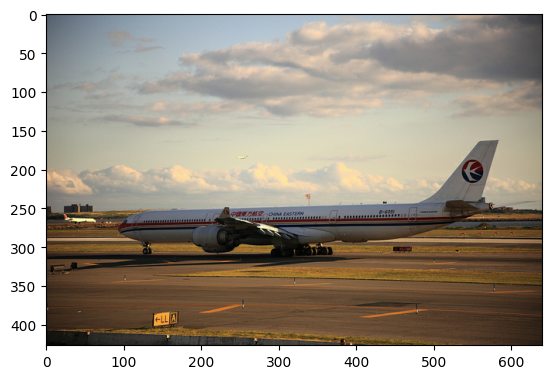

predicted caption:
 ['a', 'large', 'jetliner', 'sitting', 'on', 'top', 'of', 'a', 'runway']  classification [0.17330569]
real captions: 
['an', 'airplane', 'just', 'landed', 'on', 'the', 'runway']  classification [0.9990466]
['a', 'large', 'plane', 'sits', 'on', 'the', 'large', 'runway']  classification [0.96557903]
['a', 'large', 'white', 'airplane', 'parked', 'upon', 'a', 'runway']  classification [0.29138574]
['an', 'airplane', 'sitting', 'on', 'the', 'tarmac', 'with', 'clouds', 'above', 'it']  classification [0.9995974]
['airplane', 'on', 'the', 'runway', 'and', 'a', 'cloudy', 'sky']  classification [0.9839631]


In [20]:
from functions.model_evaluation import decode_caption
from functions.image_processing import display_image
test_image = choice(val_images)
print(test_image)

test_features = val_feature_map[test_image]
test_features = tensorflow.expand_dims(test_features, axis=0)
true_captions = val_caption_map[test_image]

test_caption = generator.generate_caption(test_features)

prediction = discriminator(test_features, test_caption)

display_image('datasets/coco/val2014', test_image)

print('predicted caption:\n', decode_caption(test_caption[0].numpy(), idx_to_word), ' classification', prediction[0].numpy())

# generate_and_evaluate_caption(test_features, idx_to_word, generator, 20, true_captions)

print('real captions: ')
for caption in val_caption_map[test_image]:
    caption_tensor = tensorflow.expand_dims(caption, axis=0)
    prediction = discriminator(test_features, caption_tensor)
    print(decode_caption(caption, idx_to_word) , ' classification', prediction[0].numpy())


In [15]:
def create_eval_dataset(images, image_features, image_captions):
    features, target_captions = [], []
    for image in images: 
        current_features = image_features[image]
        current_captions = []
        
        for caption in image_captions[image]:
            if (len(current_captions) >= 5):
                print('caption', len(current_captions),  'skipped from image ', image)
                break
            current_captions.append(convert_to_tensor(caption))
                
        features.append(current_features)
        target_captions.append(current_captions)
        
    dataset = Dataset.from_tensor_slices((features, target_captions))
    dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)
    return dataset

# eval_dataset = create_eval_dataset(val_images, val_feature_map, val_caption_map)

In [16]:
predicted_captions, true_captions = batch_generate_captions(val_images, val_feature_map, val_caption_map, idx_to_word, SEQ_LENGTH, 1024)
evaluate_captions(predicted_captions, true_captions)

([0.6562464711640911,
  0.4655218212339925,
  0.32059573872744856,
  0.22710290803115377],
 0.4385099508923216)

- training 1 = 
    - ([0.6324413703359115,
  0.43886291301506847,
  0.2887201167362333,
  0.19700841825968338],
 0.418904394023797) (wrong smoothing method used )
 - training 2, 91 epochs, 
    - ([0.5553526812523059,
  0.35532181655896167,
  0.22918829113361136,
  0.15546927729921756],
 0.36831939230308525)
- training 3, 16 epoch, discrim hid_dim doubled
  - ([0.6369256956989295,
  0.4477340858496782,
  0.3058138450452782,
  0.21467512174022885],
 0.41646065200044774)
- training 4, 30 epochs, alpha decreased to 0.1
    - ([0.6302390410278534,
  0.437418775235155,
  0.29614665149387964,
  0.20747113865267464],
 0.4127004608071282)
- training 5, 30 epochs 
  - ([0.6274449040871883,
  0.436262207094143,
  0.29650737714987624,
  0.20792691376261457],
 0.41837383253870913)
- ([0.6562464711640911,
  0.4655218212339925,
  0.32059573872744856,
  0.22710290803115377],
 0.4385099508923216) alpha 0.5, beta 2.0

In [17]:
generator.save('models/gan-generator')


INFO:tensorflow:Assets written to: models/gan-generator\assets


INFO:tensorflow:Assets written to: models/gan-generator\assets


In [18]:
from keras.models import load_model

test_model = load_model('models/gan-generator')

In [ ]:
test_features = val_feature_map[test_image]

generate_and_evaluate_test_caption('datasets/coco/val2014/', test_image, test_features, true_captions, idx_to_word, test_model, SEQ_LENGTH)


NameError: name 'generate_and_evaluate_test_caption' is not defined